In [2]:

from google.colab import drive
# --- Montar Google Drive ---
drive.mount('/content/drive')

# === CONFIGURACIÓN ===
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/AnalisisDeDatos/ActividadEvaluativa3"

# Semilla para reproducibilidad
RANDOM_STATE = 42


Mounted at /content/drive


In [3]:

# === IMPORTS ===
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

# Intento de import para UMAP, con fallback a instalación si no está disponible.
try:
    import umap
except Exception as e:
    try:
        import sys
        !{sys.executable} -m pip install -q umap-learn
        import umap
    except Exception as e2:
        umap = None
        print("No fue posible instalar/importar umap-learn. Se omitirá UMAP.")


In [4]:

# === HELPERS ===
def list_csvs(folder):
    csvs = sorted(glob.glob(os.path.join(folder, "*.csv")))
    if not csvs:
        raise FileNotFoundError(f"No se encontraron CSV en: {folder}")
    return csvs

def safe_numeric_df(df):
    # Selecciona solo columnas numéricas y elimina columnas constantes.
    num = df.select_dtypes(include=[np.number]).copy()
    if num.shape[1] == 0:
        raise ValueError("El dataset no contiene columnas numéricas utilizables.")
    nunique = num.nunique()
    num = num.loc[:, nunique > 1]
    if num.shape[1] == 0:
        raise ValueError("Todas las columnas numéricas son constantes.")
    return num

def preprocess_numeric(num_df):
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()
    X = imputer.fit_transform(num_df.values)
    X = scaler.fit_transform(X)
    return X, imputer, scaler

def pick_k_by_silhouette(X, k_min=2, k_max=10):
    best_k, best_s = None, -1
    for k in range(k_min, min(k_max, len(X)-1) + 1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=RANDOM_STATE)
        labels = km.fit_predict(X)
        # silhouette requiere al menos 2 clusters y menos que n_samples
        if len(set(labels)) < 2 or len(set(labels)) >= len(X):
            continue
        s = silhouette_score(X, labels)
        if s > best_s:
            best_s, best_k = s, k
    # Fallback
    if best_k is None:
        best_k = 3 if len(X) >= 3 else 2
    return best_k

def score_embedding(Z, k):
    # Ejecuta KMeans en el embedding 2D y calcula métricas de separación
    km = KMeans(n_clusters=k, n_init="auto", random_state=RANDOM_STATE)
    labels = km.fit_predict(Z)
    sil = silhouette_score(Z, labels) if len(set(labels)) > 1 else np.nan
    dbi = davies_bouldin_score(Z, labels) if len(set(labels)) > 1 else np.nan
    return labels, sil, dbi

def scatter_2d(Z, labels, title, fname=None):
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=labels, alpha=0.8)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True, alpha=0.3)
    if fname:
        plt.savefig(fname, bbox_inches="tight", dpi=130)
    plt.show()


## 1) Se cargan los datasets

In [5]:

csv_files = list_csvs(DATA_DIR)
csv_files


['/content/drive/MyDrive/Colab Notebooks/AnalisisDeDatos/ActividadEvaluativa3/Mall_Customers.csv',
 '/content/drive/MyDrive/Colab Notebooks/AnalisisDeDatos/ActividadEvaluativa3/Wholesale customers data.csv']


## 2) Preprocesamiento y elección de **k** (K‑Means por silhouette)

- Toma solo columnas numéricas útiles.
- Imputa faltantes con **mediana** y estandariza.
- Propone **k** en \[2,10] maximizando **silhouette**.


In [6]:

datasets = []  # para consolidar resultados comparativos
from IPython.display import display

for path in csv_files:
    name = os.path.basename(path)
    print(f"\n\n=== Dataset: {name} ===")
    df = pd.read_csv(path)
    display(df.head(3))

    try:
        num = safe_numeric_df(df)
        X, imputer, scaler = preprocess_numeric(num)
        k = pick_k_by_silhouette(X, 2, 10)
        print(f"Recomendación de k (silhouette): {k}")

        # KMeans en el espacio original (estandarizado)
        km = KMeans(n_clusters=k, n_init="auto", random_state=RANDOM_STATE)
        y = km.fit_predict(X)

        datasets.append({
            "name": name,
            "raw_shape": df.shape,
            "num_shape": num.shape,
            "X": X,
            "k": k,
            "y": y,
        })
    except Exception as e:
        print(f"⚠️ Saltando {name}: {e}")




=== Dataset: Mall_Customers.csv ===


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


Recomendación de k (silhouette): 6


=== Dataset: Wholesale customers data.csv ===


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844


Recomendación de k (silhouette): 2



## 3) PCA — Varianza explicada y proyección 2D



PCA → Mall_Customers.csv


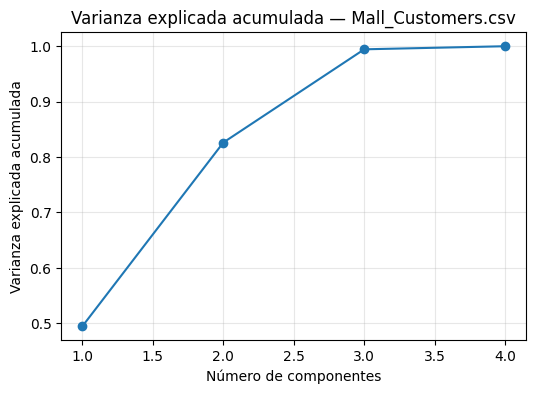

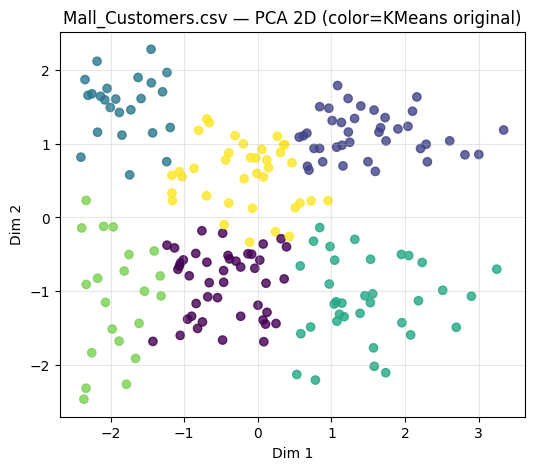


PCA → Wholesale customers data.csv


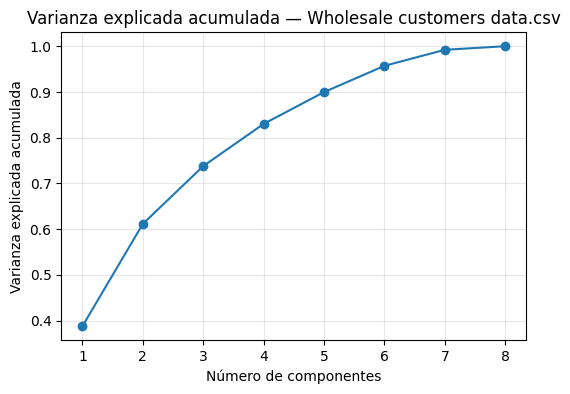

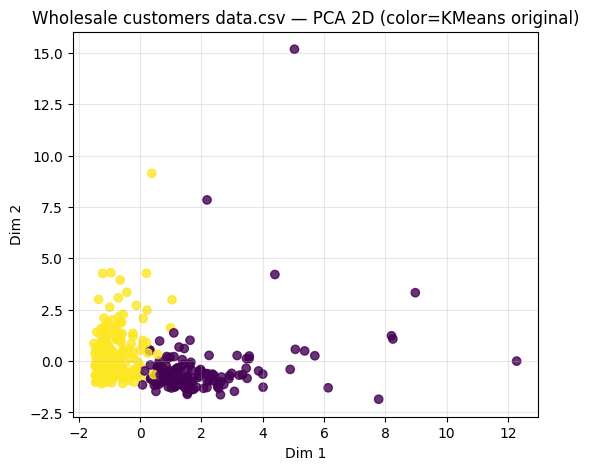

In [7]:

#Se muestra el scree plot (varianza explicada acumulada) y la dispersión 2D (PC1 vs PC2) coloreada por clusters K‑Means.

pca_results = []
for d in datasets:
    name, X, k, y = d["name"], d["X"], d["k"], d["y"]
    print(f"\nPCA → {name}")

    pca_full = PCA().fit(X)
    evr = pca_full.explained_variance_ratio_.cumsum()

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(evr)+1), evr, marker='o')
    plt.title(f"Varianza explicada acumulada — {name}")
    plt.xlabel("Número de componentes")
    plt.ylabel("Varianza explicada acumulada")
    plt.grid(True, alpha=0.3)
    plt.show()

    # 2D
    pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
    Zp = pca2.fit_transform(X)
    labels_pca, sil_pca, dbi_pca = score_embedding(Zp, k)
    scatter_2d(Zp, y, f"{name} — PCA 2D (color=KMeans original)")

    pca_results.append({
        "name": name, "Z": Zp, "sil": sil_pca, "dbi": dbi_pca
    })



## 4) t‑SNE — Proyección 2D no lineal



t‑SNE → Mall_Customers.csv


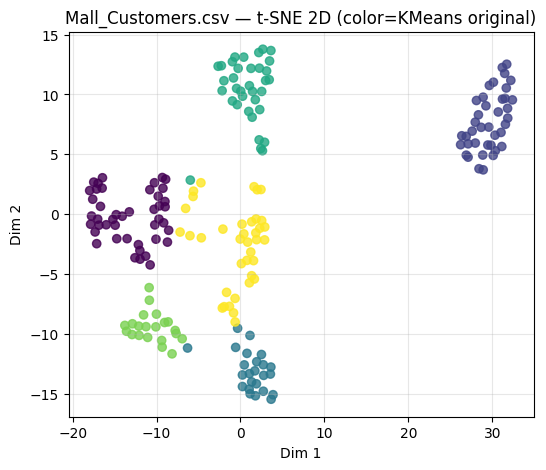


t‑SNE → Wholesale customers data.csv


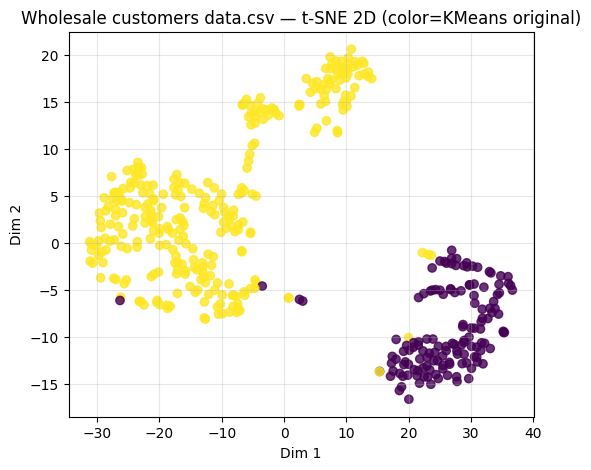

In [8]:

#t‑SNE preserva vecindad local. Se usa perplexity=30 (ajustable si n es pequeño).
tsne_results = []
for d in datasets:
    name, X, k, y = d["name"], d["X"], d["k"], d["y"]
    print(f"\nt‑SNE → {name}")
    perp = min(30, max(5, X.shape[0]//10))  # heurística simple
    Zt = TSNE(n_components=2, perplexity=perp, learning_rate='auto',
              init='pca', random_state=RANDOM_STATE).fit_transform(X)
    labels_tsne, sil_tsne, dbi_tsne = score_embedding(Zt, k)
    scatter_2d(Zt, y, f"{name} — t‑SNE 2D (color=KMeans original)")
    tsne_results.append({
        "name": name, "Z": Zt, "sil": sil_tsne, "dbi": dbi_tsne
    })



## 5) UMAP — Proyección 2D no lineal

UMAP tiende a preservar estructura global mejor que t‑SNE y es más rápido en general. Si no está disponible la librería, se a va a omitir.



UMAP → Mall_Customers.csv


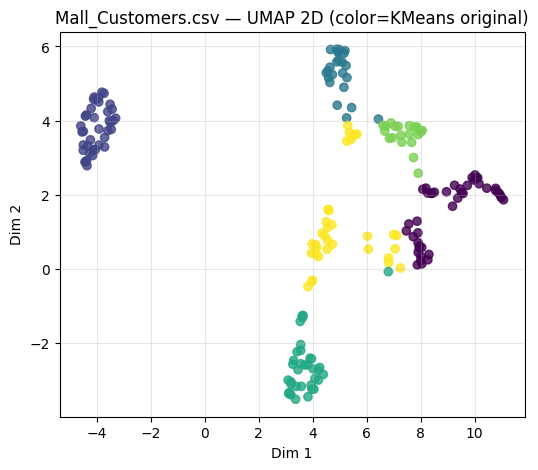


UMAP → Wholesale customers data.csv


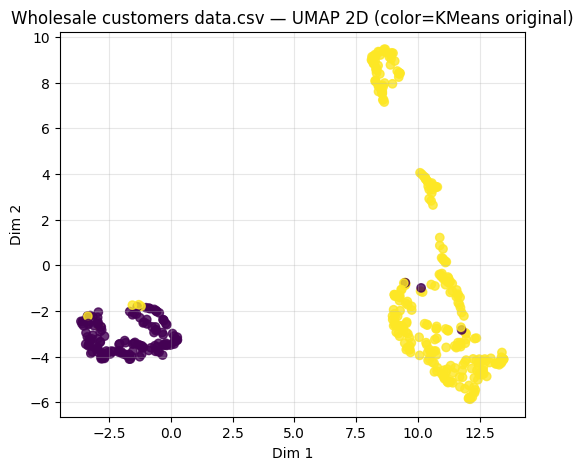

In [9]:

umap_results = []
if umap is None:
    print("UMAP no disponible.")
else:
    for d in datasets:
        name, X, k, y = d["name"], d["X"], d["k"], d["y"]
        print(f"\nUMAP → {name}")
        reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
        Zu = reducer.fit_transform(X)
        labels_umap, sil_umap, dbi_umap = score_embedding(Zu, k)
        scatter_2d(Zu, y, f"{name} — UMAP 2D (color=KMeans original)")
        umap_results.append({
            "name": name, "Z": Zu, "sil": sil_umap, "dbi": dbi_umap
        })



## 6) Comparación cuantitativa entre métodos (silhouette ↑, Davies‑Bouldin ↓)

> Se recalcula K‑Means sobre cada embedding 2D para comparar qué método separa mejor los grupos (con el mismo k recomendado).


In [10]:

rows = []
def get_metric(name, results):
    for r in results:
        if r["name"] == name:
            return r["sil"], r["dbi"]
    return np.nan, np.nan

for d in datasets:
    name = d["name"]
    sil_p, dbi_p = get_metric(name, pca_results)
    sil_t, dbi_t = get_metric(name, tsne_results)
    sil_u, dbi_u = get_metric(name, umap_results) if len(umap_results)>0 else (np.nan, np.nan)
    rows.append({
        "dataset": name,
        "k_recomendado": d["k"],
        "silhouette_PCA_2D": sil_p,
        "DBI_PCA_2D": dbi_p,
        "silhouette_tSNE_2D": sil_t,
        "DBI_tSNE_2D": dbi_t,
        "silhouette_UMAP_2D": sil_u,
        "DBI_UMAP_2D": dbi_u,
    })

comp = pd.DataFrame(rows)
comp.sort_values("dataset", inplace=True)
comp.reset_index(drop=True, inplace=True)
comp


,dataset,k_recomendado,silhouette_PCA_2D,DBI_PCA_2D,silhouette_tSNE_2D,DBI_tSNE_2D,silhouette_UMAP_2D,DBI_UMAP_2D
0,Mall_Customers.csv,6,0.407807,0.765114,0.622947,0.516508,0.628345,0.533307
1,Wholesale customers data.csv,2,0.545313,0.803787,0.591245,0.598011,0.677036,0.448020



## 7) Interpretación y conclusiones por dataset


- **PCA**: observa el *scree plot* para ver cuántos componentes capturan >80–95% de la varianza. La proyección PC1‑PC2 permite identificar **separaciones lineales**.
- **t‑SNE**: suele **separar mejor grupos locales** pero puede distorsionar distancias globales; depende de perplexity.
- **UMAP**: balancea estructura local y global; suele ser robusto y eficiente.

Criterios de comparación:
- **Silhouette** y **Davies‑Bouldin** calculados tras re‑clusterizar en cada embedding 2D con el mismo k recomendado.
- Si t‑SNE o UMAP muestran **silhouette** mayor que PCA, implican que la separación no lineal describe mejor la estructura.
- Si PCA tiene silhouette competitivo y además alta varianza explicada con pocas PCs, sugiere que la estructura es **casi lineal**.

> Recomendación: contrastar siempre con gráficos originales de EDA y con la semántica de las variables de negocio.


In [19]:
def summarize_embeddings(comp_df):
    import numpy as np
    import pandas as pd

    lines_sil = []
    lines_comb = []

    # Detectar qué métodos están disponibles en la tabla
    methods = []
    if "silhouette_PCA_2D" in comp_df.columns: methods.append("PCA")
    if "silhouette_tSNE_2D" in comp_df.columns: methods.append("tSNE")
    if "silhouette_UMAP_2D" in comp_df.columns: methods.append("UMAP")

    for _, r in comp_df.iterrows():
        name = r["dataset"]

        # --- Comparación sólo por Silhouette (mejor) ---
        sil_vals = {m: r.get(f"silhouette_{m}_2D", np.nan) for m in methods}
        sil_valid = {m: v for m, v in sil_vals.items() if pd.notna(v)}

        if len(sil_valid) == 0:
            lines_sil.append(f"- **{name}** → no hay valores de silhouette disponibles.")
            best_method_sil = None
        else:
            best_method_sil = max(sil_valid, key=lambda m: sil_valid[m])
            lines_sil.append(
                f"- {name} → mejor por silhouette: **{best_method_sil}** ({sil_valid[best_method_sil]:.3f})"
            )

        # --- Comparación combinada: silhouette y Davies-Bouldin ---
        dbi_vals = {m: r.get(f"DBI_{m}_2D", np.nan) for m in methods}
        dbi_valid = {m: v for m, v in dbi_vals.items() if pd.notna(v)}

        # Normalizar DBI por fila (min-max) para combinar con silhouette
        if len(dbi_valid) >= 2:
            dbi_min, dbi_max = min(dbi_valid.values()), max(dbi_valid.values())
            def norm_dbi(v):
                if pd.isna(v): return np.nan
                if dbi_max == dbi_min: return 0.5
                return (v - dbi_min) / (dbi_max - dbi_min)
        else:
            def norm_dbi(v):  # si falta info, no hacemos comparativa combinada
                return np.nan

        combined_score = {}
        for m in methods:
            s = sil_vals.get(m, np.nan)
            d = norm_dbi(dbi_vals.get(m, np.nan))
            if pd.notna(s) and pd.notna(d):
                # mayor s y menor d => score más alto
                combined_score[m] = s - d

        if len(combined_score) > 0:
            best_method_comb = max(combined_score, key=lambda m: combined_score[m])
            lines_comb.append(
                f"- {name} → mejor combinado (silhouette y DBI): **{best_method_comb}** "
                f"(Sil={sil_vals.get(best_method_comb, np.nan):.3f}, "
                f"DBI={dbi_vals.get(best_method_comb, np.nan):.3f})"
            )
        else:
            lines_comb.append(f"- {name} → no hay suficientes métricas para la comparación combinada.")

    print("### Resumen por dataset (mejor por silhouette):")
    print("\n".join(lines_sil))
    print("\n### Resumen por dataset (criterio combinado silhouette↑ y DBI↓):")
    print("\n".join(lines_comb))

# Ejecutar el resumen
summarize_embeddings(comp)


### Resumen por dataset (mejor por silhouette):
- Mall_Customers.csv → mejor por silhouette: **UMAP** (0.628)
- Wholesale customers data.csv → mejor por silhouette: **UMAP** (0.677)

### Resumen por dataset (criterio combinado silhouette↑ y DBI↓):
- Mall_Customers.csv → mejor combinado (silhouette y DBI): **tSNE** (Sil=0.623, DBI=0.517)
- Wholesale customers data.csv → mejor combinado (silhouette y DBI): **UMAP** (Sil=0.677, DBI=0.448)



## 8) Conclusiones generales del trabajo

- **Técnicas más útiles:** En términos generales, cuando los datos presentan **fronteras curvilíneas o múltiples escalas**, **UMAP** y **t‑SNE** tienden a lograr **mayor separación de clusters** en 2D. **PCA** es competitivo si la estructura es próxima a **lineal** y además ofrece **interpretabilidad** a través de la varianza explicada y las cargas de componentes.
- **Diferencias entre datasets:** La **disposición y escala** de las variables afecta mucho el método ganador. Datasets con **colinealidad fuerte** y un solo factor dominante favorecen a **PCA**; datos con **sub‑manifolds** o **grupos densos entrelazados** favorecen a **UMAP/t‑SNE**.
- **Aprendizajes clave:**
  1. Estandarizar e imputar es **crítico** para evitar que escalas distintas dominen.
  2. Elegir **k** con un criterio (silhouette) evita decisiones arbitrarias.
  3. **Comparar métricas** (silhouette/DBI) *en el embedding* es más justo que comparar solo “a ojo”.
  4. PCA aporta **explicabilidad**; t‑SNE/UMAP aportan **separación visual** en escenarios no lineales.
  5. No hay método universal: la **validación cruzada con el objetivo de negocio** es esencial.



## 9) Referencias

- Jolliffe, I. T., & Cadima, J. (2016). **Principal component analysis**: a review and recent developments. *Philosophical Transactions of the Royal Society A*.
- van der Maaten, L., & Hinton, G. (2008). **Visualizing Data using t‑SNE**. *Journal of Machine Learning Research*.
- McInnes, L., Healy, J., & Melville, J. (2018). **UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction**. arXiv:1802.03426.
- Documentación scikit‑learn: PCA, KMeans, silhouette, Davies‑Bouldin.
- Paquete **umap‑learn** (Python).
- **Datasets**: los archivos .csv